In [58]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from numpy.linalg import norm
from cvxopt import solvers, matrix

%load_ext autoreload
%autoreload 2

def getpoly(X,D,kernel='poly',param=2):
    P = []
    variance = np.var(X)
    for i in range(len(D)):
        row = []
        for j in range(len(D)):
            if kernel is 'poly':
                temp = D[i] * D[j] * polynomial_kernel(np.array(X[i]),np.array(X[j]),param)
            elif kernel is 'gaussian':
                temp = D[i] * D[j] * gaussian_kernel(np.array(X[i]),np.array(X[j]),variance)
            elif kernel is 'linear':
                temp = D[i] * D[j] * linear_kernel(np.array(X[i]),np.array(X[j]))               
            row.append(temp)
        P.append(row)
    return P

def getrandompointsX(a, b, n):
    x = list()
    for i in range(n):
        temp = random.uniform(a, b)
        x.append(temp)
    return x

def getdesiredpointsY(X):
    d = list()
    for x1,x2 in X:
        if (x2 < 1/5 * math.sin(10*x1) + 0.3) or ((x2 - 0.8)**2 + (x1 - 0.5)**2 < (0.15)**2):
            d.append(1)
        else:
            d.append(-1)
    return d

def linear_kernel(xi,xj):
    return np.dot(xi.T,xj)
def polynomial_kernel(Xi,Xj,d):
    return (1 + np.dot(Xi.T,Xj))**d
def gaussian_kernel(Xi,Xj,sigma):
    return math.exp(-(norm(Xi - Xj)**2/(sigma+0.5)**2))
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

def get_alpha(X,D,kernel='poly',param=2):
    P= getpoly(X,D,kernel,param)
    P = matrix(np.array(P), (len(D),len(D)), 'd')
    q = matrix(-1 * np.ones(len(D)))
    h = matrix(np.zeros(len(D)))
    G = matrix(-1 * np.eye(len(D))) ##
    b = matrix([0], (1,1), 'd')
    A = matrix(D, (1,len(D)) , 'd')
    sol=solvers.qp( P, q, G, h, A, b)
    return (np.array(list(sol['x'])))

#filtering for best 10
def get_support_vector(alpha):
    k= np.argwhere(alpha > 0.0001)
    return k

def get_theta(alpha,X,D,K,kernel='poly',param=2):
    temp = 0
    variance = np.var(X)
    for i in range(len(D)):
        if kernel is 'poly':
             temp += alpha[i] * D[i] * polynomial_kernel(np.array(X[i]),np.array(X[K]),param) # param: degree for poly kernel
        elif kernel is 'linear':
            temp += alpha[i] * D[i] * linear_kernel(np.array(X[i]),np.array(X[K]))
        elif kernel is 'gaussian':
            temp += alpha[i] * D[i] * gaussian_kernel(np.array(X[i]),np.array(X[K]),variance) #parma: not needes , based on the variance
    theta = D[K] - temp
    return theta

def get_gx(alpha,X,D,theta,Ik,Xk,kernel='poly',param=2):
    temp = 0
    variance = np.var(X)
    for i in Ik:
        if kernel is 'poly':
            temp += alpha[i] * D[i] * polynomial_kernel(np.array(X[i]),Xk,param)
        elif kernel is 'linear':
            temp += alpha[i] * D[i] * linear_kernel(np.array(X[i]),Xk)
        elif kernel is 'gaussian':
            temp += alpha[i] * D[i] * gaussian_kernel(np.array(X[i]),Xk,variance)
    g_x = temp + theta
    return(g_x)

X1 = getrandompointsX(0, 1, 100)
X2 = getrandompointsX(0, 1, 100)
X = [[ele1,ele2] for ele1,ele2 in zip(X1,X2)]
D = getdesiredpointsY(X)

alpha = get_alpha(X,D,'gaussian')
K = get_support_vector(alpha)

K= [idx for idx,val in enumerate(alpha) if float(val)>0.001]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
     pcost       dcost       gap    pres   dres
 0: -5.6453e+01 -1.4777e+02  3e+02  1e+01  2e+00
 1: -1.4692e+02 -2.5096e+02  2e+02  6e+00  1e+00
 2: -3.8423e+02 -5.1744e+02  2e+02  5e+00  1e+00
 3: -8.4727e+02 -1.0475e+03  2e+02  5e+00  1e+00
 4: -1.4232e+03 -1.6908e+03  3e+02  5e+00  1e+00
 5: -2.5552e+03 -2.9898e+03  5e+02  5e+00  1e+00
 6: -5.2636e+03 -6.3680e+03  1e+03  4e+00  8e-01
 7: -8.2937e+03 -1.0215e+04  2e+03  2e+00  5e-01
 8: -9.2642e+03 -9.8233e+03  6e+02  4e-01  7e-02
 9: -9.2855e+03 -9.2935e+03  8e+00  5e-03  1e-03
10: -9.2855e+03 -9.2856e+03  8e-02  5e-05  1e-05
11: -9.2855e+03 -9.2855e+03  8e-04  5e-07  1e-07
12: -9.2855e+03 -9.2855e+03  8e-06  5e-09  1e-09
Optimal solution found.


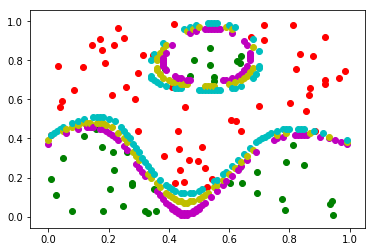

In [59]:
for (x, y), d in zip(X, D):
    if d is 1:
        plt.scatter(x, y, color='g', marker='o')
    elif d is -1:
        plt.scatter(x, y, color='r', marker='o')
theta = get_theta(alpha,X, D, K[1], kernel="gaussian")
new_range = np.arange(0, 1, 0.01)
for x1 in new_range:
    for x2 in new_range:
        g = get_gx(alpha, X, D, theta,Ik=K, Xk=np.array([x1, x2]),kernel= 'gaussian')
        if (g <= 1.1 and g >= 0.9):
            plt.scatter(x1, x2, color='m', marker='o')
        if ((g >= -1.1) and (g <= -0.9)):
            plt.scatter(x1, x2, color='c', marker='o')
        if ((g >= -0.1) and (g <= 0.1)):
            plt.scatter(x1, x2, color='y', marker='o')
plt.show()
  

#### Points : Green = H+ , Red = H- 